# Détection des piscines

## Définition de l'environnement de travail 

In [3]:
import os
from arcgis.gis import GIS
gis = GIS('https://maps.esrifrance.fr/portal', 'mlemoigne', '123Azerty!')

## Données géographiques en entrée

<Item title:"Zones de recherche de piscines" type:Map Image Layer owner:mlemoigne>
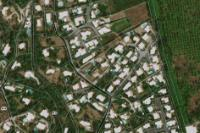

In [4]:
#Chargement de la couche de recherche
recherche = gis.content.get('cce5fb01da35430dae52533be6e95ed7')
recherche

In [ ]:
#Définition de l'étendue de travail
from arcgis.geocoding import geocode
etendue = geocode('Juvignac', out_sr=3857)[0]['extent']

In [ ]:
#Création des enveloppes servant à délimiter chaque communes
from arcgis.geometry import Envelope
from arcgis.features import SpatialDataFrame
etendue_generale = Envelope(etendue)

df = SpatialDataFrame.from_layer(fl_recherche.layers[0])
couche_recherche = list(df['SHAPE'].extent)

zones_recherche = [Envelope({"xmin": x[0], "ymin": x[1], "xmax": x[2], "ymax": x[3], "spatialReference": 2154}) for x in couche_recherche]

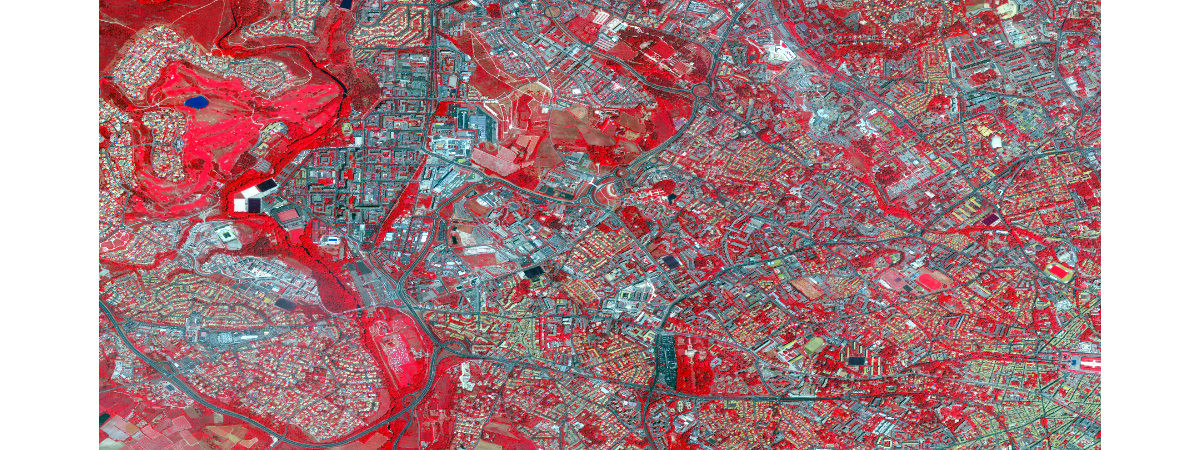

In [5]:
from arcgis.raster.functions import apply

#Chargement de l'imagerie
digital_globe = gis.content.search('802765ccc2b945fd9683f191e253e7a6')[0]

#Sélection du rendu infrarouge
digital_layer = digital_globe.layers[0]
digitalIr = apply(digital_layer, 'false composite')
digitalIr

## Exécution du modèle

In [2]:
#Import de Pytorch pour l'utilisation de la GPU
import torch
import torch.nn as nn
torch.backends.cudnn.benchmark=True

#Import de fonctions et classes définies dans le fichier util.py
from util import load_model, norm, denorm, export_img, get_tile_images, get_img, \
        get_cropped_tiles, predict_, detect_objects, suppress_close_pools, overlap, predict_classf, resultats

#Import de fonctions et classes définies dans le fichier model.py
from model import ConvnetBuilder, SSD_MultiHead, resnet34, k

#Sélection et paramétrage de l'architecture du réseau de neurone
f_model = resnet34
pretrained = "model_piscine.h5"

head_reg = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg)
model = models.model
model = load_model(model, pretrained)
model.eval()

path = "C:/demonstration/pleniere/machinelearning/data/resultats"

In [910]:
#Définition des bordures et rognures des boîtes d'ancrage (anchor boxes)
import math

pixx, pixy = 90, 90
N = 8
w = h = N*pixx - pixx/2

nX = math.ceil((etendue_generale['xmax'] - etendue_generale['xmin'])/w)
nY = math.ceil((etendue_generale['ymax'] - etendue_generale['ymin'])/h)

objects    = []
inferenced = []
done_imgs  = {}

borders = [ (45,   45,   45,   45),   # xmin, ymin, xmax, ymax
          (22.5, 22.5, 67.5, 67.5),   # coin en bas à gauche
          (22.5, 67.5, 67.5, 22.5),   # coin en haut à gauche
          (67.5, 22.5, 22.5, 67.5),   # coin en bas à droite
          (67.5, 67.5, 22.5, 22.5) ]  # coin en haut à gauche

crops   = [ (112, 112, 112, 112),  # xmin, ymax, xmax, ymin
            ( 56, 168, 168,  56),  # coin en bas à gauche
            ( 56,  56, 168, 168),  # coin en haut à gauche
            (168, 168,  56,  56),  # coin en bas à droite
            (168,  56,  56, 168) ] # coin en haut à gauche

In [911]:
#Détection
import numpy as np
from PIL import Image

for i in range(nX):
    for j in range(nY):
        filename = f'DigitalGlobe_{i}_{j}.jpg'

        xmin = etendue_generale['xmin'] + (j)*w
        ymin = etendue_generale['ymax'] - (i+1)*h
        xmax = xmin + N*pixx
        ymax = ymin + N*pixy

        ext = {'xmin':xmin, 'ymin':ymin, 'xmax':xmax, 'ymax':ymax, 'spatialReference':3857}
        
        for zone in zones_recherche:
            if (overlap(zone, ext)):
                print(filename, 'Detecting...')

                imgpath = path + filename

                if not os.path.isfile(imgpath):
                    print(filename, 'Downloading...')
                    imgpath = digitalIr.export_image(ext, image_sr={'wkid': 4326}, 
                                         bbox_sr=3857, size=[224*8, 224*8], f='image', 
                                         export_format='jpg', adjust_aspect_ratio=False,
                                         mosaic_rule={"mosaicMethod": "esriMosaicAttribute",
                                                      "mosaicOperation":"MT_FIRST"},
                                                      save_folder=path,
                                                      save_file=filename)

                if filename not in inferenced:                        
                    img = np.array(Image.open(imgpath))

                    tiles = get_tile_images(img)
                    pools = detect_objects(model, tiles, ext, cycle=0)
                    print(filename, 'Resultat : ' + str(len(pools)) + ' piscines (pass #0)')
                    objects.extend(pools)

                    for iii, crop in enumerate(crops):
                        paddedtiles = get_cropped_tiles(img, crop)
                        pools = detect_objects(model, paddedtiles, ext, crop=borders[iii], cycle=iii+1)
                        print(filename, 'Resultat ' + str(len(pools)) + f' piscines (pass #{iii+1})')
                        objects.extend(pools)

                    inferenced.append(filename)

DigitalGlobe_1_2.jpg Detecting...
DigitalGlobe_1_2.jpg Downloading...
DigitalGlobe_1_2.jpg Resultat : 196 piscines (pass #0)
DigitalGlobe_1_2.jpg Resultat 125 piscines (pass #1)
DigitalGlobe_1_2.jpg Resultat 113 piscines (pass #2)
DigitalGlobe_1_2.jpg Resultat 148 piscines (pass #3)
DigitalGlobe_1_2.jpg Resultat 112 piscines (pass #4)
DigitalGlobe_1_2.jpg Resultat 150 piscines (pass #5)
DigitalGlobe_1_3.jpg Detecting...
DigitalGlobe_1_3.jpg Downloading...
DigitalGlobe_1_3.jpg Resultat : 131 piscines (pass #0)
DigitalGlobe_1_3.jpg Resultat 72 piscines (pass #1)
DigitalGlobe_1_3.jpg Resultat 59 piscines (pass #2)
DigitalGlobe_1_3.jpg Resultat 104 piscines (pass #3)
DigitalGlobe_1_3.jpg Resultat 58 piscines (pass #4)
DigitalGlobe_1_3.jpg Resultat 101 piscines (pass #5)
DigitalGlobe_1_4.jpg Detecting...
DigitalGlobe_1_4.jpg Downloading...
DigitalGlobe_1_4.jpg Resultat : 148 piscines (pass #0)
DigitalGlobe_1_4.jpg Resultat 86 piscines (pass #1)
DigitalGlobe_1_4.jpg Resultat 75 piscines (pas

DigitalGlobe_4_8.jpg Resultat 4 piscines (pass #3)
DigitalGlobe_4_8.jpg Resultat 7 piscines (pass #4)
DigitalGlobe_4_8.jpg Resultat 6 piscines (pass #5)
DigitalGlobe_4_9.jpg Detecting...
DigitalGlobe_4_9.jpg Downloading...
DigitalGlobe_4_9.jpg Resultat : 9 piscines (pass #0)
DigitalGlobe_4_9.jpg Resultat 6 piscines (pass #1)
DigitalGlobe_4_9.jpg Resultat 8 piscines (pass #2)
DigitalGlobe_4_9.jpg Resultat 10 piscines (pass #3)
DigitalGlobe_4_9.jpg Resultat 10 piscines (pass #4)
DigitalGlobe_4_9.jpg Resultat 11 piscines (pass #5)
DigitalGlobe_4_10.jpg Detecting...
DigitalGlobe_4_10.jpg Downloading...
DigitalGlobe_4_10.jpg Resultat : 16 piscines (pass #0)
DigitalGlobe_4_10.jpg Resultat 13 piscines (pass #1)
DigitalGlobe_4_10.jpg Resultat 12 piscines (pass #2)
DigitalGlobe_4_10.jpg Resultat 13 piscines (pass #3)
DigitalGlobe_4_10.jpg Resultat 7 piscines (pass #4)
DigitalGlobe_4_10.jpg Resultat 10 piscines (pass #5)
DigitalGlobe_4_11.jpg Detecting...
DigitalGlobe_4_11.jpg Downloading...
Dig

DigitalGlobe_8_3.jpg Resultat : 133 piscines (pass #0)
DigitalGlobe_8_3.jpg Resultat 68 piscines (pass #1)
DigitalGlobe_8_3.jpg Resultat 109 piscines (pass #2)
DigitalGlobe_8_3.jpg Resultat 61 piscines (pass #3)
DigitalGlobe_8_3.jpg Resultat 109 piscines (pass #4)
DigitalGlobe_8_3.jpg Resultat 58 piscines (pass #5)
DigitalGlobe_8_4.jpg Detecting...
DigitalGlobe_8_4.jpg Downloading...
DigitalGlobe_8_4.jpg Resultat : 157 piscines (pass #0)
DigitalGlobe_8_4.jpg Resultat 87 piscines (pass #1)
DigitalGlobe_8_4.jpg Resultat 120 piscines (pass #2)
DigitalGlobe_8_4.jpg Resultat 82 piscines (pass #3)
DigitalGlobe_8_4.jpg Resultat 123 piscines (pass #4)
DigitalGlobe_8_4.jpg Resultat 80 piscines (pass #5)
DigitalGlobe_8_5.jpg Detecting...
DigitalGlobe_8_5.jpg Downloading...
DigitalGlobe_8_5.jpg Resultat : 147 piscines (pass #0)
DigitalGlobe_8_5.jpg Resultat 79 piscines (pass #1)
DigitalGlobe_8_5.jpg Resultat 121 piscines (pass #2)
DigitalGlobe_8_5.jpg Resultat 75 piscines (pass #3)
DigitalGlobe_8

## Nettoyage des résultats et création de la couche des piscines

In [912]:
#Transformation de la liste "objects" en flux de caractères
#pour la sauvegarder et s'en servir comme clé de dictionnaire
import pickle 

pickle.dump(objects, open(path + 'objects.pkl', 'wb'))
objects = pickle.load(open(path + 'objects.pkl', 'rb'))

In [913]:
#Création d'un spatial data frame
for i, obj in enumerate(objects):
    obj['SHAPE'] = {'x': obj['x'], 'y': obj['y']}
sdf = SpatialDataFrame.from_dict(objects)
sdf = sdf.reset_index()
sdf.sr = {'wkid': 3857}

In [914]:
#Suppression des piscines détectées à moins de 15 mètres les unes des autres (faux positifs)
#et conservation de celle qui détient le plus haut taux de confiance
piscines, piscines_supprimees = suppress_close_pools(sdf, 15)

In [924]:
#Conversion du SpatialDataFrame en Feature Collection pour la jointure
piscines_fc = piscines.to_feature_collection(name="piscines")

#Obtention des parcelles
parcelles = gis.content.get('522898b3688640b2857cf32f00e417de')
parcelles_couche = parcelles.layers[0]
parcelles_couche.filter="(bati = 'Oui')"

#Jointure des piscines et parcelles
from arcgis.features.summarize_data import join_features

piscines_parcelles = join_features(piscines_fc, parcelles_couche,
                                           join_operation='JoinOneToMany',
                                           spatial_relationship='intersects')

In [925]:
#On conserve une piscine par parcelle (celle avec le plus gros score)
dfpiscines = piscines_parcelles.query().sdf
dfpiscines_max = (dfpiscines.groupby(by='codeident').apply(lambda x: x.loc[x.c_score.idxmax(), :]))
dfpiscines_max.reset_index(drop=True, inplace=True)

dfpiscines_geo = SpatialDataFrame(data=dfpiscines_max)
SHAPE = dfpiscines_geo['SHAPE'].copy()
del dfpiscines_geo['SHAPE']
dfpiscines_geo = dfpiscines_geo.set_geometry(SHAPE)
dfpiscines_geo.sr = {'wkid': 3857}

piscines_detectees = gis.content.import_data(dfpiscines_geo, title='piscines_detectees', tags='deeplearning')
piscines_detectees

<Item title:"piscines_detectees" type:Feature Layer Collection owner:mlemoigne>

In [927]:
#création du service des parcelles jointes avec les piscines détectées
parcelles_piscines = join_features(parcelles_couche, piscines_detectees.layers[0], 
                                    join_operation='JoinOneToMany',
                                    spatial_relationship='intersects',
                                    output_name="Parcelles_piscines")
parcelles_piscines

<Item title:"Parcelles_piscines" type:Feature Layer Collection owner:mlemoigne>

# Analyse des résultats

## Analyse comparative cadastre/modèle

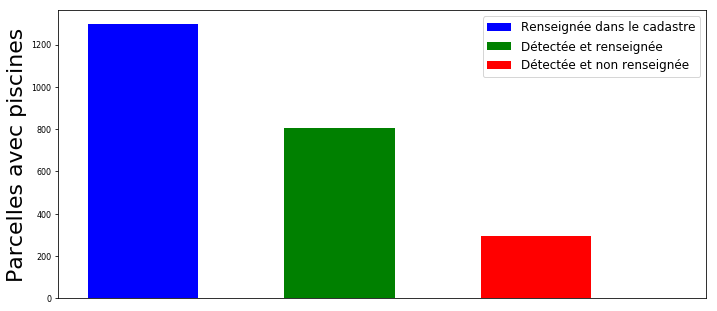

In [38]:
piscines_detectees = gis.content.get('f88d8a5c4abf49b28ba06b93c3047982')
parcelles_couche = gis.content.get('522898b3688640b2857cf32f00e417de').layers[0]

#Comparaison réalité / modèle
%matplotlib inline
import matplotlib.pyplot as plt

dfparcelles_stats = parcelles_couche.query(where="extra = 'Oui'").sdf
dfpiscines_oui = piscines_detectees.layers[0].query(where="extra = 'Oui'").sdf
dfpiscines_non = piscines_detectees.layers[0].query(where="extra = 'Non'").sdf

fig, ax = plt.subplots(1,1)
fig.tight_layout()


left  = 0  # the left side of the subplots of the figure
right = 1.5    # the right side of the subplots of the figure
bottom = 0   # the bottom of the subplots of the figure
top = 1.0      # the top of the subplots of the figure
wspace = 0.5   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots


plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

legend = ['Renseignée dans le cadastre', 'Détectée et renseignée', 'Détectée et non renseignée']
ax.hist([dfparcelles_stats.extra, dfpiscines_oui.extra, dfpiscines_non.extra], color=['blue', 'green', 'red'], bins=1, width = 0.15)
ax.legend(legend, prop={'size': 12})
ax.set_ylabel('Parcelles avec piscines', fontsize=22)    
ax.tick_params(direction='out', labelsize=8 )
plt.show()

In [1]:
#Carte générale
from IPython.display import IFrame
IFrame('http://scene3/parcelles', width=980, height=600)

## Analyse des parcelles ayant une piscine non renseignée dans le cadastre

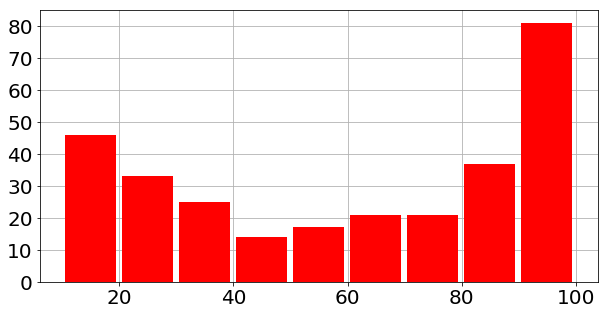

In [10]:
#Représentation du nombre de piscines détectées aux différents intervalles de confiance
%matplotlib inline
import matplotlib.pyplot as plt

dfpiscines_non['score'].hist(bins=9, grid=True, figsize=(10,5), color='red', zorder=2, rwidth=0.9, xlabelsize = 20, ylabelsize = 20)

In [1]:
from IPython.display import IFrame
IFrame('http://scene3/piscines', width=980, height=750)